#Analysis of the Fitzhugh Nagumo Model

##No Extensions are performed (he says lying through his teeth)

###Import all necessary modules

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# need to clone and install from https://github.com/jakevdp/JSAnimation.git
from JSAnimation import IPython_display

from matplotlib import animation
from scipy.integrate import odeint
from scipy.signal import argrelextrema
%matplotlib inline

###Initialize Constants

In [19]:
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 200.0 #ms
numpoints = 10*stoptime
times = np.linspace(0,stoptime,numpoints)

###Initialize Variables

In [4]:
alpha = 0.01;
beta = 0.5;
c = 0.1;
z = 0.5;

In [35]:
#ignore my stupid comments

#Derrivatives
def dV(V,W,alpha,z):
    return V*(alpha+V)*(1-V)-W+z
def dW(V,W,beta,c):
    return beta*V - c*W

#Nullclines
def nullV(alpha,V):
    return -V**3 + (1-alpha)*V**2 + alpha*V +z
def nullW(beta,c,V):
    return beta*V/c

#Bulk derrivative for ode solver
def derr_func(var,t,p):
    alpha,beta,c,z = p
    V, W = var
    f = [V*(alpha+V)*(1-V)-W+z, beta*V - c*W]
    return f

#calculate frequency of model
def calc_freq(t,V):
    t = t[500:] #so only looking after 500
    V = V[500:]
    peak_max = np.max(V)
    
    ########### maybe changing this #################
    peak_range = 0.75*peak_max #why 95? maybe we can do a differnt one here
    ################################################
    
    max_pts = argrelextrema(V,np.greater)[0]
    max_ranges = np.where(V[max_pts] >= peak_range)
    max_pts = max_pts[max_ranges]
    
    time_pts = t[max_pts]
    return 1.0/np.diff(time_pts)[-2]

###Sample Run of Model

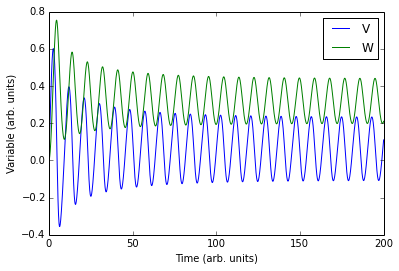

In [24]:
#use ode solver
p = [alpha, beta, c, z]
w0 = [0,0]


wsol = odeint(derr_func, [0,0], times, args=([alpha,beta,c,z],),atol=abserr, rtol=relerr)
V = wsol[:,0]
W = wsol[:,1]
plt.plot(times,V)
plt.plot(times,W)
plt.xlabel('Time (arb. units)')
plt.ylabel('Variable (arb. units)')
plt.legend(['V','W'])

###Phase Plane

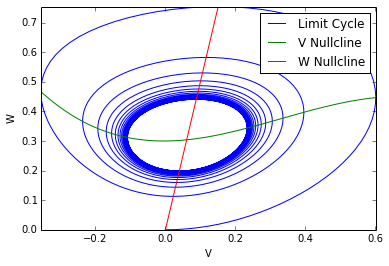

In [25]:
plt.plot(V,W)
Vs = np.linspace(min(V),max(V),100)
V_nullcline = nullV(alpha,Vs)
W_nullcline = nullW(beta,c,Vs)

plt.plot(Vs,V_nullcline)
plt.plot(Vs,W_nullcline)
plt.xlim([min(V),max(V)])
plt.ylim([min(W),max(W)])

plt.legend(['Limit Cycle','V Nullcline','W Nullcline'])
plt.xlabel('V')
plt.ylabel('W')

###Phase Plane Animation

In [36]:
n_z = 50
zs = np.linspace(0,5,n_z)
V_loop = np.zeros((n_z,np.size(V)))
W_loop = np.zeros((n_z,np.size(W)))

null_Vs = np.linspace(-2,2,10000)
nullclines = np.zeros((2,n_z,len(null_Vs)))
for ix,z in enumerate(zs):
    wsol = odeint(derr_func, [0,0], times, args=([alpha,beta,c,z],),atol=abserr, rtol=relerr)
    V = wsol[:,0]
    W = wsol[:,1]
    V_loop[ix,:] = V
    W_loop[ix,:] = W
    nullclines[0,ix,:] = nullV(alpha,null_Vs)
    nullclines[1,ix,:] = nullW(beta,c,null_Vs)
    
#First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
V_lim = (np.min(np.min(V_loop)),np.max(np.max(V_loop)))
W_lim = (np.min(np.min(W_loop)),np.max(np.max(W_loop)))

ax = plt.axes(xlim=V_lim, ylim=W_lim)

lines = []
for i in [0,1,2]:
    lines.append(ax.plot([],[],lw=2)[0])
def init():
        lines[0].set_data([], [])
        lines[1].set_data([], [])
        lines[2].set_data([], [])
        return lines,

def animate(i):
    V = V_loop[i,:]
    W = W_loop[i,:]
    lines[0].set_data(V, W)
    lines[1].set_data(null_Vs,nullclines[0,i,:])
    lines[2].set_data(null_Vs,nullclines[1,i,:])
    return lines


animation.FuncAnimation(fig, animate, init_func=init,frames=n_z, interval=100, blit=True)

ValueError: could not broadcast input array from shape (1000) into shape (2000)

###Stability analysis at $z=0$

Taking the initial model

$$\begin{align}
f(x) &= \dot{V} = V(\alpha + V)(1-V) -W +z \\
g(x) &= \dot{W} = \beta V -cW
\end{align}
$$


We evaluate thejacobian matrix

$$
\overrightarrow{J} = \begin{bmatrix}
    \frac{\partial f}{\partial{V}} & \frac{\partial f}{\partial{W}} \\
    \frac{\partial g}{\partial{V}} & \frac{\partial g}{\partial{W}} \\
\end{bmatrix} = 
\begin{bmatrix}
    -3V^2+(1-\alpha)V +\alpha & -1 \\
    \beta & -c \\
\end{bmatrix}
$$

If we take $\alpha,\beta,c$ equal to 0.01,0.5,0.1, we get $\Rightarrow $
$$
\begin{bmatrix}
    -3V^2+(1.98)V+0.01 & -1 \\
    0.5 & -0.1 \\    
\end{bmatrix}
$$

This implies that eigenvalues $\lambda_{1,2}$ may be complex or not

$$
\lambda_{1,2} = \frac{1}{2} (-v^2+1.01v \pm \sqrt{v^4+2.02v^3+2.8401v^2-1.8382v-1.1719}-1.11)
$$

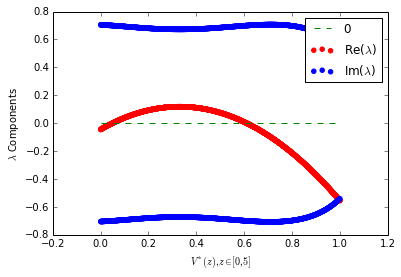

In [27]:
def eig12(v):
    v = v+0j
    e1 = 0.5*(-3*(v**2)+1.98*v-np.sqrt(9*(v**4)-11.88*(v**3)+3.2604*(v**2)+0.4356*v-1.9879)-0.09)
    e2 = 0.5*(-3*(v**2)+1.98*v+np.sqrt(9*(v**4)-11.88*(v**3)+3.2604*(v**2)+0.4356*v-1.9879)-0.09)
    return (e1,e2)

zs = np.linspace(0,5,1000)
v = np.zeros(len(zs))
for ix,z in enumerate(zs):
    coeff = [-1,(1-alpha),alpha-(beta)/c,z]
    r = np.roots(coeff)
    r = np.real(r[np.isreal(r)])
    v[ix] = r[0]
    
eigs = eig12(v)
v = np.concatenate((v,v))
zs = np.concatenate((zs,zs))
re = np.concatenate((np.real(eigs[0]),np.real(eigs[1])))
im = np.concatenate((np.imag(eigs[0]),np.imag(eigs[1])))
plt.scatter(v,re,label='Re($\lambda$)',color='red')
plt.scatter(v,im,label='Im($\lambda$)',color='blue')
plt.plot([min(v),max(v)],[0,0],'g--',label='0')
plt.legend()
plt.xlabel('$V^*(z), z\in[0,5]$')
plt.ylabel('$\lambda$ Components')

###Low Resolution Bifurcation diagram WRT $z$

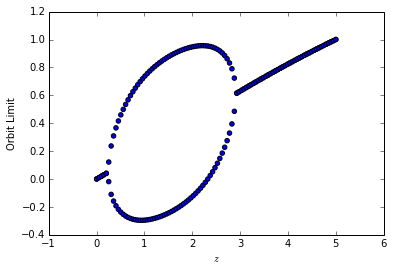

In [10]:
p = [alpha, beta, c, z]
w0 = [0,0]
times = np.linspace(0,5000,1000)
zs = np.linspace(0,5,100)
points = np.zeros((len(zs),2))
for ix,z in enumerate(zs):
    wsol = odeint(derr_func, [0,0], times, args=([alpha,beta,c,z],),atol=abserr, rtol=relerr)
    V = wsol[:,0]
    points[ix,:] = [min(V[500:]),max(V[500:])]

points_x = []
for z in zs:
    points_x.append(z)
    points_x.append(z)
plt.scatter(points_x,points)
plt.xlabel("$z$")
plt.ylabel("Orbit Limit")

###High Resolution Bifurcation diagram WRT $z$

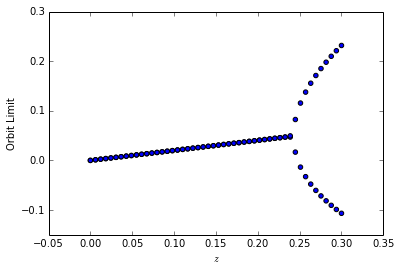

In [11]:
p = [alpha, beta, c, z]
w0 = [0,0]
times = np.linspace(0,10000,1000)
zs = np.linspace(0,0.3,50)                
points = np.zeros((len(zs),2))
for ix,z in enumerate(zs):
    wsol = odeint(derr_func, [0,0], times, args=([alpha,beta,c,z],),atol=abserr, rtol=relerr)
    V = wsol[:,0]
    points[ix,:] = [min(V[500:]),max(V[500:])]

points_x = []
for z in zs:
    points_x.append(z)
    points_x.append(z)
plt.scatter(points_x,points)
plt.xlabel('$z$')
plt.ylabel('Orbit Limit')

###2 Coupled Neurons

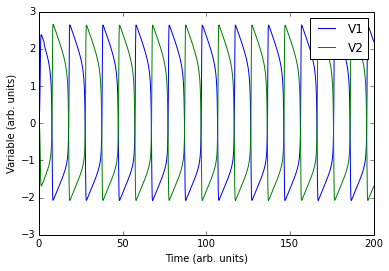

In [12]:
def derr_func_coup(var,t,p):
    alpha,beta,c,z,gamma = p
    V1,V2,W1,W2 = var
    G_bar = 2
    f = [V1*(alpha+V1)*(1-V1)-W1+z*(t<3)+G_bar*(1-gamma)*(V1-V2),
         V2*(alpha+V2)*(1-V2)-W2+G_bar*(1-gamma)*(V2-V1),
         beta*V1 - c*W1,
         beta*V2 - c*W2]
    return f


times = np.linspace(0,200,1000)
p = [alpha, beta, c, z,0]
w0 = [0,0,0,0]
wsol = odeint(derr_func_coup, [0,0,0,0], times, args=([alpha,beta,c,0.5,0],),atol=abserr, rtol=relerr)
V1 = wsol[:,0]
V2 = wsol[:,1]
plt.plot(times,V1)
plt.plot(times,V2)
plt.xlabel('Time (arb. units)')
plt.ylabel('Variable (arb. units)')
plt.legend(['V1','V2'])

###Coupling Animation


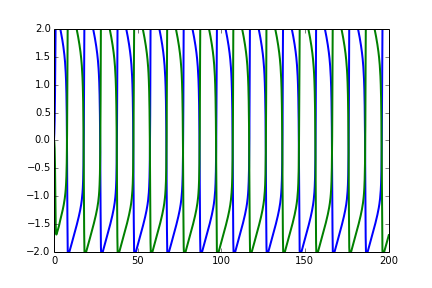
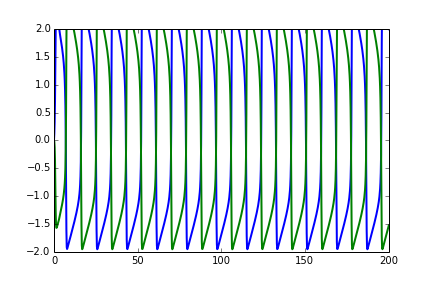
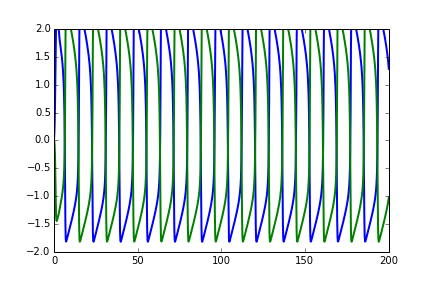
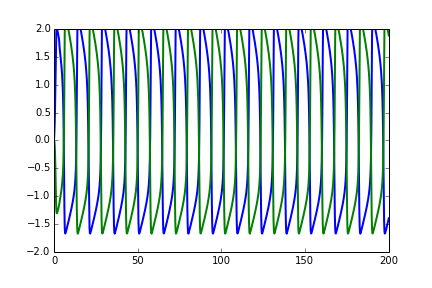
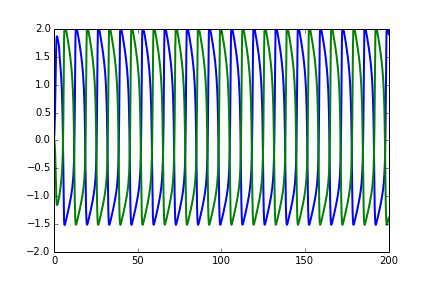
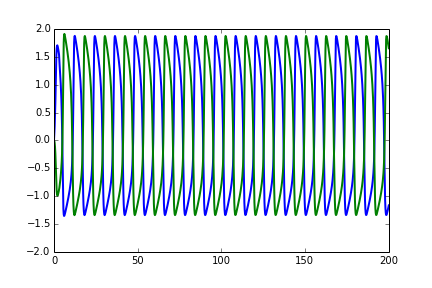
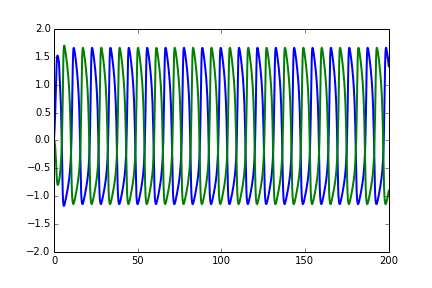
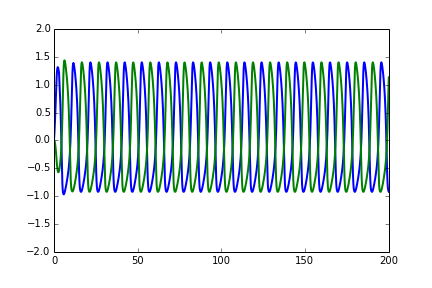
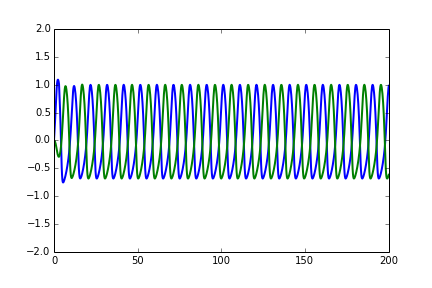
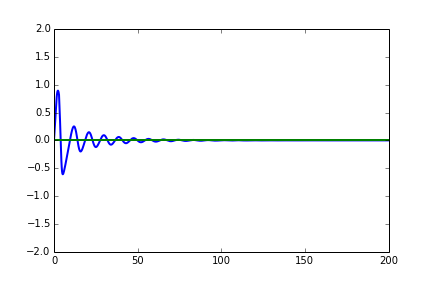

In [13]:
n_gamma = 10
gammas = np.linspace(0,1,n_gamma)
V1_loop = np.zeros((n_gamma,np.size(V1)))
V2_loop = np.zeros((n_gamma,np.size(V2)))
for ix,gamma in enumerate(gammas):
    p = [alpha, beta, c, z,gamma]
    w0 = [0,0,0,0]
    wsol = odeint(derr_func_coup, [0,0,0,0], times, args=([alpha,beta,c,0.5,gamma],),atol=abserr, rtol=relerr)
    V1 = wsol[:,0]
    V2 = wsol[:,1]
    V1_loop[ix,:] = V1
    V2_loop[ix,:] = V2
    

    
#First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0,200), ylim=(-2,2))

lines = []
for i in [0,1]:
    lines.append(ax.plot([],[],lw=2)[0])
def init():
        lines[0].set_data([], [])
        lines[1].set_data([], [])
        return lines,

def animate(i):
    V1 = V1_loop[i,:]
    V2 = V2_loop[i,:]
    lines[0].set_data(times,V1)
    lines[1].set_data(times,V2)
    return lines


animation.FuncAnimation(fig, animate, init_func=init,frames=n_gamma, interval=100, blit=True)

###$n$ coupled neurons

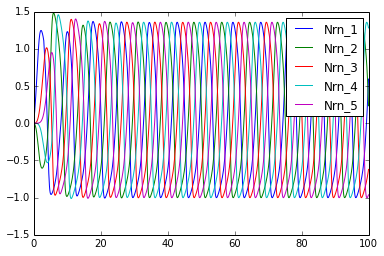

In [39]:
times = np.linspace(0,100,1000)
def derr_func_coup_bulk(var,t,p):
    alpha,beta,c,z,gamma = p
    #var = v1,v2,v3... w1,w2,w3...
    G_bar = 0.5
    x = np.zeros(len(var))
    n_nrn = len(var)/2.0
    vs = var[0:n_nrn]
    ws = var[n_nrn:]
    #vs = np.concatenate((vs,[vs[0]]))
    #ws = np.concatenate((ws,[ws[0]]))
    x[0] = (vs[0]*(alpha+vs[0])*(1-vs[0]))-ws[0]+(z*(t<3))+(G_bar*(1-gamma)*(vs[0]-vs[-1]))#*((vs[0]-vs[-1])>0)
    x[0+n_nrn] = beta*vs[0] - c*ws[0]
    for i in np.arange(1,n_nrn):
        x[i] = (vs[i]*(alpha+vs[i])*(1-vs[i]))-ws[i]+(G_bar*(1-gamma)*(vs[i]-vs[i-1]))#*((vs[i]-vs[i-1])>0)
        x[i+n_nrn] = beta*vs[i] - c*ws[i]
    return x

gamma = 0
n_nrn = 5


p = [alpha, beta, c, 0.5,gamma]
w = np.zeros(n_nrn*2)
wsol = odeint(derr_func_coup_bulk,w, times, args=(p,),atol=abserr, rtol=relerr)
VS = wsol[:,:n_nrn]
names = []
for i in np.arange(n_nrn):
    names.append('Nrn_'+str(i+1))
plt.plot(times,VS)
plt.legend(names)

###$n$ coupled neurons with diode

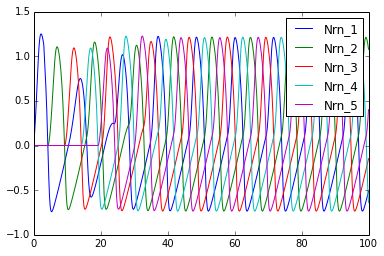

In [37]:
#n_nrns = number of neurons

times = np.linspace(0,100,1000)
def derr_func_coup_bulk_forward_positive(var,t,p):
    alpha,beta,c,z,gamma = p
    #var = v1,v2,v3... w1,w2,w3...
    G_bar = 0.5
    x = np.zeros(len(var))
    n_nrn = len(var)/2.0
    vs = var[0:n_nrn]
    ws = var[n_nrn:]
    #vs = np.concatenate((vs,[vs[0]]))
    #ws = np.concatenate((ws,[ws[0]]))
    x[0] = (vs[0]*(alpha+vs[0])*(1-vs[0]))-ws[0]+(z*(t<3))+(G_bar*(1-gamma)*(vs[0]-vs[-1]))*((vs[0]-vs[-1])>0)
    x[0+n_nrn] = beta*vs[0] - c*ws[0]
    for i in np.arange(1,n_nrn):
        x[i] = (vs[i]*(alpha+vs[i])*(1-vs[i]))-ws[i]+(G_bar*(1-gamma)*(vs[i]-vs[i-1]))*((vs[i]-vs[i-1])>0)
        x[i+n_nrn] = beta*vs[i] - c*ws[i]
    return x

gamma = 0
n_nrn = 5


p = [alpha, beta, c, 0.5,gamma]
w = np.zeros(n_nrn*2)
wsol = odeint(derr_func_coup_bulk_forward_positive,w, times, args=(p,),atol=abserr, rtol=relerr)
VS = wsol[:,:n_nrn]
names = []
for i in np.arange(n_nrn):
    names.append('Nrn_'+str(i+1))
plt.plot(times,VS)
plt.legend(names)

###Frequency - needs more work

In [ ]:
gamma = 0
n_max = 50

VS = np.zeros((len(times),n_max-1))
nrns = np.zeros(n_max-1)
for i in np.arange(n_max-1):
    n_nrn = i+2
    print n_nrn
    nrns[i] = n_nrn
    p = [alpha, beta, c, 0.5,gamma]
    w = np.zeros(n_nrn*2)
    wsol = odeint(derr_func_coup_bulk,w, times, args=(p,),atol=abserr, rtol=relerr)
    VS[:,i] = wsol[:,0]
    
freqs = np.zeros(n_max-1)
for ix in np.arange(n_max-1):
    freqs[ix] = calc_freq(times,VS[:,ix])
plt.plot(nrns,freqs)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25